In [38]:
# Multi-Class Logistic Regression

In [1]:
import numpy as np
import tensorflow as tf

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Prepararing data

In [3]:
M = 2
K = 3
n = 100
N = K * n

In [4]:
rng = np.random.RandomState(123)

In [13]:
X1 = np.hstack([
        np.ones(n)[:, np.newaxis],
        rng.randn(n, M) + np.array([0, 10])
    ])
X2 = np.hstack([
        np.ones(n)[:, np.newaxis],
        rng.randn(n, M) + np.array([5, 5])
    ])
X3 = np.hstack([
        np.ones(n)[:, np.newaxis],
        rng.randn(n, M) + np.array([10, 0])
    ])

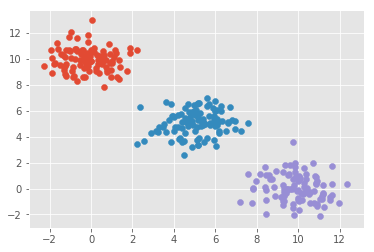

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X1[:, 1], X1[:, 2])
ax.scatter(X2[:, 1], X2[:, 2])
ax.scatter(X3[:, 1], X3[:, 2])
plt.show()

In [15]:
X = np.vstack([X1, X2, X3])

In [16]:
Y = np.vstack([
        np.array([[1, 0, 0] for _ in range(n)]),
        np.array([[0, 1, 0] for _ in range(n)]),
        np.array([[0, 0, 1] for _ in range(n)])
    ])

In [17]:
# Bulding a model

In [42]:
global_graph = tf.Graph()
with global_graph.as_default():
    sess = tf.Session()

In [44]:
with global_graph.as_default():
    W = tf.Variable(tf.zeros([M+1, K]))
    
    x = tf.placeholder(tf.float32, shape=[None, M+1])
    t = tf.placeholder(tf.float32, shape=[None, K])
    
    with tf.name_scope('Product_1'):
        y = tf.nn.softmax(tf.matmul(x, W))

    with tf.name_scope('Loss_Function'):
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y), 1))
    
    with tf.name_scope('Optimizer'):
        train_step = tf.train.GradientDescentOptimizer(1.0e-1).minimize(cross_entropy)
    
    show_graph(sess.graph_def)

In [27]:
# Training the model

In [45]:
from sklearn.utils import shuffle

In [46]:
epoch_num = 20
batch_size = 50
batch_num = N // batch_size

with global_graph.as_default():    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epoch_num):
        X_, Y_ = shuffle(X, Y)
            
        for i in range(batch_num):
            start = i * batch_size
            end = start + batch_size
            
            sess.run(train_step,
                     feed_dict={
                         x: X_[start:end],
                         t: Y_[start:end]
                     })
        

In [32]:
# Confirming the result

In [47]:
with global_graph.as_default():
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))

In [48]:
X_, Y_ = shuffle(X, Y)

In [49]:
with global_graph.as_default():
    classified = correct_prediction.eval(
                    session=sess,
                    feed_dict={
                        x: X_[0:10],
                        t: Y_[0:10]
                    })
    
    prob = y.eval(session=sess,
                  feed_dict={
                      x: X_[0:10]
                  })

In [50]:
print("Classified: {0}".format(classified))
print("Probability] {0}".format(prob))

Classified: [ True  True  True  True  True  True  True  True  True  True]
Probability] [[  9.94301677e-01   5.69834281e-03   3.24543348e-09]
 [  1.22766942e-02   9.61004794e-01   2.67185755e-02]
 [  9.91899610e-01   8.10034014e-03   1.08961276e-08]
 [  9.97457087e-01   2.54290644e-03   5.81123483e-10]
 [  2.25086976e-03   9.71485019e-01   2.62640733e-02]
 [  1.00782346e-02   9.85286474e-01   4.63521853e-03]
 [  9.89574134e-01   1.04258778e-02   1.28572140e-08]
 [  2.84921975e-10   1.90197001e-03   9.98098075e-01]
 [  1.21922312e-08   6.33077836e-03   9.93669212e-01]
 [  2.10075751e-02   9.30775523e-01   4.82168309e-02]]
